# Open Food Facts: the carbon “food-print” we do not eat

## Abstract
<i>Everything we do has a carbon footprint, and our diet is no exception. From growing, farming, processing and packaging our food, energy and organic resources are consumed and released, which reflects in the emission of greenhouse gases, like CO<sub>2</sub>. In our project, we analyze the processed foods industry - its manufacturing, product composition, and sales - for the main sources of carbon emissions, using the Open Food Facts dataset. We explain the carbon footprint repartition, starting on an understanding of the products, followed by the breakdown of production countries as well as point of sales and evaluating trends in diet composition, with a special focus on nutritionally high marked products in France and the UK. 

With this study, we want to provide a better understanding of the agri-food industry, and eventually help reducing carbon emissions.</i>

In this notebook, we are performingt the above analysis on the OpenFoodFacts database, which we pre-processed using the __Open Food Facts - Cleanse Data__ notebook in the main directory.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Abstract" data-toc-modified-id="Abstract-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Abstract</a></span></li><li><span><a href="#Import-cleansed-data" data-toc-modified-id="Import-cleansed-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import cleansed data</a></span></li><li><span><a href="#Analyse-data" data-toc-modified-id="Analyse-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analyse data</a></span><ul class="toc-item"><li><span><a href="#Production-/-manufacture-impact" data-toc-modified-id="Production-/-manufacture-impact-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Production / manufacture impact</a></span><ul class="toc-item"><li><span><a href="#Global-distribution-of-global-food-producers" data-toc-modified-id="Global-distribution-of-global-food-producers-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Global distribution of global food producers</a></span><ul class="toc-item"><li><span><a href="#Which-are-the-dominant-global-food-producers-and-manufacturers?" data-toc-modified-id="Which-are-the-dominant-global-food-producers-and-manufacturers?-3.1.1.1"><span class="toc-item-num">3.1.1.1&nbsp;&nbsp;</span>Which are the dominant global food producers and manufacturers?</a></span></li><li><span><a href="#How-is-this-distribution-impacted-when-we-consider-neutral-and-large-carbon-footprint-products?" data-toc-modified-id="How-is-this-distribution-impacted-when-we-consider-neutral-and-large-carbon-footprint-products?-3.1.1.2"><span class="toc-item-num">3.1.1.2&nbsp;&nbsp;</span>How is this distribution impacted when we consider neutral and large carbon footprint products?</a></span></li></ul></li><li><span><a href="#Case-study:-Palm-oil" data-toc-modified-id="Case-study:-Palm-oil-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Case study: Palm oil</a></span><ul class="toc-item"><li><span><a href="#Can-we-observe-any-trend-in-the-number-of-products-including-this-oil-(assuming-a-strong-dependence-between-date-the-product-was-added-to-the-database-and-data-the-product-was-invented)?" data-toc-modified-id="Can-we-observe-any-trend-in-the-number-of-products-including-this-oil-(assuming-a-strong-dependence-between-date-the-product-was-added-to-the-database-and-data-the-product-was-invented)?-3.1.2.1"><span class="toc-item-num">3.1.2.1&nbsp;&nbsp;</span>Can we observe any trend in the number of products including this oil (assuming a strong dependence between date the product was added to the database and data the product was invented)?</a></span></li><li><span><a href="#Which-country-use-palm-oils-for-production?" data-toc-modified-id="Which-country-use-palm-oils-for-production?-3.1.2.2"><span class="toc-item-num">3.1.2.2&nbsp;&nbsp;</span>Which country use palm oils for production?</a></span></li></ul></li></ul></li><li><span><a href="#Good-nutrition-impact" data-toc-modified-id="Good-nutrition-impact-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Good nutrition impact</a></span><ul class="toc-item"><li><span><a href="#High-nutrional-products" data-toc-modified-id="High-nutrional-products-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>High-nutrional products</a></span><ul class="toc-item"><li><span><a href="#Has-there-been-a-surge-in-high-graded-Products-in-the-UK-/-France-over-the-past-years?" data-toc-modified-id="Has-there-been-a-surge-in-high-graded-Products-in-the-UK-/-France-over-the-past-years?-3.2.1.1"><span class="toc-item-num">3.2.1.1&nbsp;&nbsp;</span>Has there been a surge in high graded Products in the UK / France over the past years?</a></span></li><li><span><a href="#What-are-those-products-made-of?" data-toc-modified-id="What-are-those-products-made-of?-3.2.1.2"><span class="toc-item-num">3.2.1.2&nbsp;&nbsp;</span>What are those products made of?</a></span></li><li><span><a href="#Where-do-these-product-come-from-and-where-are-they-manufactured?" data-toc-modified-id="Where-do-these-product-come-from-and-where-are-they-manufactured?-3.2.1.3"><span class="toc-item-num">3.2.1.3&nbsp;&nbsp;</span>Where do these product come from and where are they manufactured?</a></span></li><li><span><a href="#Where-are-those-products-sold?" data-toc-modified-id="Where-are-those-products-sold?-3.2.1.4"><span class="toc-item-num">3.2.1.4&nbsp;&nbsp;</span>Where are those products sold?</a></span></li></ul></li><li><span><a href="#Carbon-footprint-of-nutrionally-high-graded-products" data-toc-modified-id="Carbon-footprint-of-nutrionally-high-graded-products-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Carbon footprint of nutrionally-high graded products</a></span><ul class="toc-item"><li><span><a href="#Is-there-a-general-correlation-between-high-carbon-footprint-and-price?" data-toc-modified-id="Is-there-a-general-correlation-between-high-carbon-footprint-and-price?-3.2.2.1"><span class="toc-item-num">3.2.2.1&nbsp;&nbsp;</span>Is there a general correlation between high carbon footprint and price?</a></span></li></ul></li></ul></li></ul></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from scipy import stats
from datetime import datetime

import json
import pickle

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%load_ext autoreload
%autoreload 2
    
import libs.exploring as explore
import libs.visualising as visualize
import libs.cleansing as cleanse

# Set up plotly environment
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

## Import cleansed data

In [2]:
# Import data
open_food_facts_csv_file = "./data/openfoodfacts_clean.csv"

food_facts_pd = pd.read_csv(open_food_facts_csv_file,
                            delimiter="\t")

In [3]:
# Change column data types
food_facts_pd['carbon-footprint_100g'] = food_facts_pd['carbon-footprint_100g'].apply(pd.to_numeric, args=('coerce',))
food_facts_pd['energy_100g'] = food_facts_pd['energy_100g'].apply(pd.to_numeric, args=('coerce',))
food_facts_pd['price_per_100g'] = food_facts_pd['price_per_100g'].apply(pd.to_numeric, args=('coerce',))
food_facts_pd['created_datetime'] = food_facts_pd['created_datetime'].apply(pd.to_datetime, args=('coerce',))

# Replace missing values
food_facts_pd.origins_cleaned= food_facts_pd.origins_cleaned.fillna("['Unknown']")
food_facts_pd.manufacturing_place_cleaned= food_facts_pd.manufacturing_place_cleaned.fillna("['Unknown']")
food_facts_pd.purchase_places_cleaned= food_facts_pd.purchase_places_cleaned.fillna("['Unknown']")
# food_facts_pd = food_facts_pd.fillna('')

# List tags
food_facts_pd.origins_cleaned = \
    food_facts_pd.origins_cleaned.apply(lambda l: cleanse.read(l))

food_facts_pd.manufacturing_place_cleaned = \
    food_facts_pd.manufacturing_place_cleaned.apply(lambda l: cleanse.read(l))

food_facts_pd.purchase_places_cleaned = \
                        food_facts_pd.purchase_places_cleaned.apply(lambda l: cleanse.read(l))

In [4]:
food_facts_pd.head(5)

,Unnamed: 0,code,created_t,created_datetime,product_name,quantity,packaging,brands,categories_en,labels_en,...,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,origins_cleaned,manufacturing_place_cleaned,purchase_places_cleaned,price_per_100g,store_currency
0,0,0000000274722,1514659309,2017-12-30 18:41:49,Blanquette de Volaille et son Riz,NaN,"carton,plastique",Comme J’aime,"Meals,Meat-based products,Meals with meat,Poul...","['Viande Française', 'Made In France']",...,Meats,450.0,NaN,0.0,0.0,[Unknown],[France],[France],NaN,NaN
1,1,0000000394710,1484497370,2017-01-15 16:22:50,Danoises à la cannelle roulées,1.150 kg,Frais,Kirkland Signature,"Sugary snacks,Biscuits and cakes,Pastries",[''],...,Sugary snacks,1520.0,NaN,NaN,NaN,[France],[France],[France],NaN,NaN
2,2,0000001071894,1409411252,2014-08-30 15:07:32,Flute,NaN,"Paper,plastic film",Waitrose,"Plant-based foods and beverages,Plant-based fo...",[''],...,Plant-based,NaN,NaN,NaN,NaN,[Canada],[Unknown],[Canada],NaN,NaN
3,3,0000001938067,1484501528,2017-01-15 17:32:08,Chaussons tressés aux pommes,1.200 kg,Frais,Kirkland Signature,"Sugary snacks,Biscuits and cakes,Pastries",[''],...,Sugary snacks,1090.0,NaN,9.0,9.0,[France],[United Kingdom],[United Kingdom],NaN,NaN
4,4,0000004302544,1488464896,2017-03-02 14:28:16,Pain Burger Artisan,1.008 kg / 12 pain,"Frais,plastique",Kirkland Signature,boulange,[''],...,Boulange,1160.0,NaN,1.0,1.0,[Canada],[Unknown],[Canada],NaN,NaN


Additionally to the OpenFoodFact dataset, we obtained an extract of the Eaternity dataset hosted by the ETH Zurich, which contains 692 more products and their CO2 footprint. Unfortunately, these products are not contained in the OpenFoodFacts database, so we lack manufacturing and purchasing information as well as the OpenFoodFacts categories for this set.

In [5]:
# Import data
carbon_footprint_csv_file = "./data/carbon_footprint_categories.csv"

carbon_footprint_pd = pd.read_csv(carbon_footprint_csv_file, delimiter="\t")
carbon_footprint_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692 entries, 0 to 691
Data columns (total 13 columns):
Unnamed: 0                      692 non-null int64
Unnamed: 0.1                    692 non-null int64
ID                              692 non-null int64
Title                           692 non-null object
Weight [gram/serving]           692 non-null int64
CO2-Value [gram CO2/serving]    692 non-null float64
CO2 rating                      692 non-null float64
FAT                             692 non-null float64
WATER                           692 non-null float64
ENERC                           692 non-null float64
PROT                            692 non-null float64
category                        692 non-null object
category_en                     692 non-null object
dtypes: float64(6), int64(4), object(3)
memory usage: 70.4+ KB


In [6]:
carbon_footprint_pd.head(5)

,Unnamed: 0,Unnamed: 0.1,ID,Title,Weight [gram/serving],CO2-Value [gram CO2/serving],CO2 rating,FAT,WATER,ENERC,PROT,category,category_en
0,0,0,4300175162708,K Classic - Junger Gemüsemais,100,9.0,20.812,3.480252,52.999834,765.655520,8.601195,Gemüsekonserven,Tinned vegetables
1,1,1,4388840231829,ja! Gemüsemais,100,17.0,37.941,2.312597,35.218431,1070.401621,5.715417,Gemüsekonserven,Tinned vegetables
2,2,2,8851613101392,Aroy-D - Kokosnussmilch,100,35.0,47.490,25.200000,33.860000,1230.000000,5.340000,Kokosmilch,Coconut milk
3,3,3,4003994111000,Kelloggs Cornflakes Die Originalen 375 g,100,29.0,50.203,2.305610,10.145873,1458.792557,7.147392,"Ceralien, Cornflakes","Cereals, cornflakes"
4,4,4,4005009100542,Tortilla Chips Meersalz,100,55.0,53.102,25.168000,5.083000,1918.400000,13.321000,Tortilla Chips,Tortilla chips


## Analyse data

Before we analyse the data, we have to some confesssions to make:

The data that we loaded into this notebook was already preprocessed in the "Open Food Facts - Cleanse data" notebook, that can be found in the same directory. In there we translated countries, labels, and categories and formatted and matched tags. However, we also droped more than 90% of the data set, because the data points were not complete for the purpose of our analysis.

OpenFoodFacts was initiated in France, and products sold in france are dominantly represented in this data set. Moreover, most of the products are sold in Europe or industrial nations, and we have no or only sparse data about the African, Asian, Australian, and South-american continent, which excludes the majority of the world population and especially the societes in Asia and Africa, that undergo the most decisive transformations at the moment.

Further, we only have qualitative data about the products, but no quantities that are produced and purchased world wide, hence we cannot provide a scale for all the insights that we gain throughout this notebook.

What we are trying to say is, that the data is under no circumstances representive to analyse the the research questions that we have posed. However, we will provide the methods to perform this analysis on this comprised dataset, and see what kind of insights we can already squeek out of it.

### Production / manufacture impact

#### Global distribution of global food producers

In [7]:
countries_label = pd.read_csv("./data/country_lookup.csv")[['name', 'cca3']]     

##### Which are the dominant global food producers and manufacturers?

- From where are those products originating?

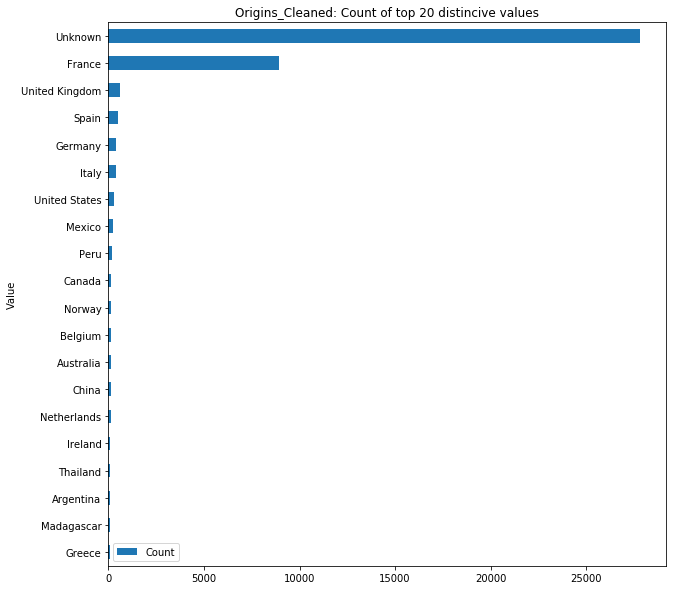

In [8]:
values_set, values_count_origins = visualize.plot_occurences_of_distinct_values(food_facts_pd, 'origins_cleaned')

In [9]:
values_count_origins = pd.DataFrame.from_dict(values_count_origins, orient='index', columns=['Count']).reset_index().rename(index=str, columns={"index": "Country", "Count": "Count"})
values_count_origins = values_count_origins[values_count_origins.Country != "Unknown"]
values_count_origins['cca3'] = values_count_origins.Country.apply(lambda l: visualize.search_cca3(l, countries_label))
values_count_origins['Count'] = values_count_origins.Count.apply(lambda l: np.log(l))
values_count_origins= values_count_origins[['cca3', 'Count']]

In [10]:
country_geo = './data/world-countries.json'

m = folium.Map(location=[0, 0], tiles='Mapbox Bright', zoom_start=1.5, control_scale= True)

# choropleth maps bind Pandas Data Frames and json geometries.
folium.Choropleth(geo_data=country_geo,
               data=values_count_origins,
               columns=['cca3', 'Count'],
               fill_color='YlGnBu',
               nan_fill_color='purple', 
               nan_fill_opacity=0.4,
               key_on='feature.id',
               threshold_scale=[0, 1, 2, 5,8,11],
               legend_name='Origin Country : logscale of entries (base 10) [Countries in purple are empty]',
               fill_opacity=0.7, 
               line_opacity=0.2,
               ).add_to(m)
m.save("folium-palm_oil_products-origin_countries.html")
m

Note that country in purple are  not assigned any value. 

- Where are those products manufactured?

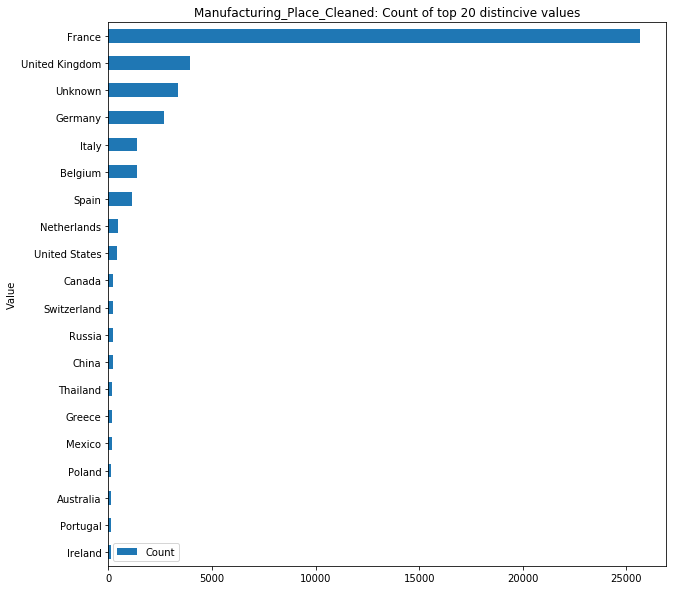

In [11]:
values_set, values_count_manufacturing = visualize.plot_occurences_of_distinct_values(food_facts_pd, 'manufacturing_place_cleaned')

In [12]:
values_count_manufacturing = pd.DataFrame.from_dict(values_count_manufacturing, orient='index', columns=['Count']).reset_index().rename(index=str, columns={"index": "Country", "Count": "Count"})
values_count_manufacturing = values_count_manufacturing[values_count_manufacturing.Country != "Unknown"]
values_count_manufacturing['cca3'] = values_count_manufacturing.Country.apply(lambda l: visualize.search_cca3(l, countries_label))
values_count_manufacturing['Count'] = values_count_manufacturing.Count.apply(lambda l: np.log(l))
values_count_manufacturing= values_count_manufacturing[['cca3', 'Count']]

In [13]:
df = values_count_manufacturing

In [14]:
# Load the first sheet of the JSON file into a data frame
countries = pd.read_json('./data/countries_latlon.json')

# TODO Set colorscale
# TODO change color of missing countries
# TODO scale of both maps accordingly
# TODO delete map and make lines thinner

worldmap = [ dict(
        type = 'choropleth',
        locations = df['cca3'],
        z = df['Count'],
        text = df['cca3'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
                [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        colorbar = dict(
            autotick = True,
            title = 'Counts'),
      ) ]

lines = []
france_latlng = countries.loc[countries['cca3'] == 'FRA']['latlng'].iloc[0]
for i, row in values_count_manufacturing.iterrows():
    country_latlng = countries.loc[countries['cca3'] == row['cca3']]['latlng'].iloc[0]
    lines.append(
        dict(
            type = 'scattergeo',
            lon = [ country_latlng[1], france_latlng[1] ],
            lat = [ country_latlng[0], france_latlng[0] ],
            mode = 'lines',
            line = dict(
                width = row['Count'],
                color = 'red',
            ),
        )
    )

layout = dict(
    title = 'Manufacturing countries for products sold in France',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'equirectangular'
        )
    ),
    showlegend=False,
    xaxis = dict(fixedrange = True),
    yaxis = dict(fixedrange = True)

)

fig = dict( data=worldmap + lines, layout=layout )
iplot( fig, validate=False, filename='d3-world-map' )

In [15]:
country_geo = './data/world-countries.json'

m = folium.Map(location=[0, 0], tiles='Mapbox Bright', zoom_start=1.5)

# choropleth maps bind Pandas Data Frames and json geometries.
folium.Choropleth(geo_data=country_geo,
               data=values_count_manufacturing,
               columns=['cca3', 'Count'],
               fill_color='YlGnBu', 
               nan_fill_color='purple', 
               nan_fill_opacity=0.4,
               key_on='feature.id',
               threshold_scale=[0, 1, 2, 5,8,11],
               legend_name='Manufacturing : logscale of entries (base 10) [Countries in purple are empty]',
               fill_opacity=0.7, 
               line_opacity=0.2,
               ).add_to(m)
m.save("folium-palm_oil_products-production_countries.html")
m

- Where are those products bought?

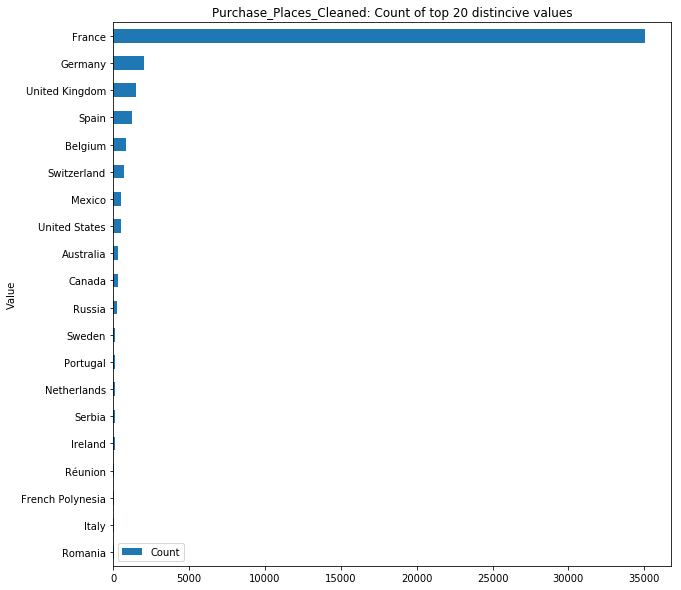

In [16]:
values_set, values_count_purchase = visualize.plot_occurences_of_distinct_values(food_facts_pd, 'purchase_places_cleaned')

In [17]:
values_count_purchase = pd.DataFrame.from_dict(values_count_purchase, orient='index', columns=['Count']).reset_index().rename(index=str, columns={"index": "Country", "Count": "Count"})
values_count_purchase = values_count_purchase[values_count_purchase.Country != "Unknown"]
values_count_purchase['cca3'] = values_count_purchase.Country.apply(lambda l: visualize.search_cca3(l, countries_label))
values_count_purchase['Count'] = values_count_purchase.Count.apply(lambda l: np.log(l))
values_count_purchase= values_count_purchase[['cca3', 'Count']]


In [18]:
country_geo = './data/world-countries.json'

m = folium.Map(location=[0, 0], tiles='Mapbox Bright', zoom_start=1.5)

# choropleth maps bind Pandas Data Frames and json geometries.
folium.Choropleth(geo_data=country_geo,
               data=values_count_purchase,
               columns=['cca3', 'Count'],
               fill_color='YlGnBu',
               nan_fill_color='purple', 
               nan_fill_opacity=0.4,
               key_on='feature.id',
               threshold_scale=[0, 1, 2, 5,8,11],
               legend_name='Purchasing : logscale of entries (base 10) [Countries in purple are empty]',
               fill_opacity=0.7, 
               line_opacity=0.2,
               ).add_to(m)
m.save("folium-palm_oil_products-purchase_countries.html")
m

In conclusion, we note that we mainly have data for "western" countries, with a huge bias toward France. We mostly lack information for country in Africa and the centre of Asia. Our dataset is thus clearly not a truthful representation of the world. We shall therefore restrict our analysis to the case of France, meaning purchases countries will be limited to the case of France. [This category was selected since it is the most furnished one.] 

This is carried out in the next cell. Note that <i> purchases_places_cleaned </i> is only requested to contain 'France' as one of the entries in its list, there could be more than one. 

In [19]:
food_facts_pd['filter'] = food_facts_pd.purchase_places_cleaned.apply(lambda l: explore.filter_france(l))
food_facts_pd = food_facts_pd[food_facts_pd['filter'] == 'France'].drop(columns=['filter'])

##### How is this distribution impacted when we consider neutral and large carbon footprint products? 

In [24]:
# dataset carbon footprint coming from Eaternity
# This will be assess in future version of this project
food_facts_pd.main_category

0                             Meats
1                     Sugary snacks
6                             Meats
7                         Beverages
10                    Sugary snacks
13              Dietary Supplements
17                    Sugary snacks
21              Dietary Supplements
22                    Sugary snacks
25                    Sugary snacks
27                    Sugary snacks
29                    Sugary snacks
30                    Sugary snacks
31                     Frozen foods
32                       Breakfasts
33                      Plant-based
34              Dietary Supplements
35                    Sugary snacks
36                    Sugary snacks
37                    Sugary snacks
38                   Tarta-De-Trigo
41                    Sugary snacks
42                     Salty snacks
43                      Plant-based
45              Dietary Supplements
46             Confitures-De-Cassis
47                      Plant-based
48                      Plan

In [25]:
import gensim

In [30]:
# Load Google's pre-trained Word2Vec model.
model =gensim.models.KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin.gz', binary=True)  

2018-12-07 16:03:32,312 : INFO : loading projection weights from ./data/GoogleNews-vectors-negative300.bin.gz
2018-12-07 16:05:01,789 : INFO : loaded (3000000, 300) matrix from ./data/GoogleNews-vectors-negative300.bin.gz


In [100]:
def vectorize_words(column_to_vectorize):
    sep_words = []
    word_vectorized = []
    for i in range (len(column_to_vectorize)):
        try:
            word = column_to_vectorize.iloc[i]
            print(i,word)
            if((' ' in word) == True): 
                words = word.split()
                mean = 0
                for i in range(len(words)):
                    word_vec = model[words[i]]
                    mean += word_vec/len(words)
            elif(('-' in word) == True):
                words = word.split('-')
                mean = 0
                for i in range(len(words)):
                    word_vec = model[words[i]]
                    mean += word_vec/len(words)
            else :
                word_vec = model[word]
        except:
            print(word,'not found')
            word_vec = 'None'
        word_vectorized.append(word_vec)
    return word_vectorized


In [101]:
vect_food = vectorize_words(food_facts_pd.main_category)
vect_carbon = vectorize_words(carbon_footprint_pd.category)

0 Meats
1 Sugary snacks
2 Meats
3 Beverages
4 Sugary snacks
5 Dietary Supplements
6 Sugary snacks
7 Dietary Supplements
8 Sugary snacks
9 Sugary snacks
10 Sugary snacks
11 Sugary snacks
12 Sugary snacks
13 Frozen foods
14 Breakfasts
15 Plant-based
16 Dietary Supplements
17 Sugary snacks
18 Sugary snacks
19 Sugary snacks
20 Tarta-De-Trigo
21 Sugary snacks
22 Salty snacks
23 Plant-based
24 Dietary Supplements
25 Confitures-De-Cassis
Confitures-De-Cassis not found
26 Plant-based
27 Plant-based
28 Meats
29 Frozen foods
30 25Cl
25Cl not found
31 Plant-based
32 Sugary snacks
33 Beverages
34 Plant-based
35 Sugary snacks
36 Sugary snacks
37 Meats
38 Dairies
39 Plant-based
40 Plant-based
41 Meats
42 Beverages
43 Frozen foods
44 Farines
Farines not found
45 Meats
46 Beverages
47 Sugary snacks
48 Petit-Dejeuners
Petit-Dejeuners not found
49 Meals
50 Sugary snacks
51 Sugary snacks
52 Carbs
53 Sugary snacks
54 Plant-based
55 Plant-based
56 Beverages
57 Frozen foods
58 Plant-based
59 Groceries
60 Be

921 Beverages
922 Beverages
923 Sugary snacks
924 Plant-based
925 Sugary snacks
926 Plant-based
927 Beverages
928 Roast-Ham
929 Frozen-Asian-Foods
930 Plant-based
931 Carbs
932 Plant-based
933 Plant-based
934 Organic-Vegetables
935 Seafood
936 Beverages
937 Dairies
938 Dairies
939 Beverages
940 Kiwi-Fruit
941 Beverages
942 Seafood
943 Seafood
944 Plant-based
945 Meals
946 Dairies
947 Sugary snacks
948 Plant-based
949 Dairies
950 Plant-based
951 Sugary snacks
952 Beverages
953 Fromages
954 Fats
955 Dairies
956 Sugary snacks
957 Groceries
958 125-Kcal
125-Kcal not found
959 Carbs
960 Creme-Patissiere
Creme-Patissiere not found
961 Sugary snacks
962 Dairies
963 Plant-based
964 Dairies
965 Sugary snacks
966 Sugary snacks
967 Sugary snacks
968 Fruits-Secs
969 Plant-based
970 Dairies
971 Plant-based
972 Sauce-Froide
Sauce-Froide not found
973 Dairies
974 Sugary snacks
975 Beverages
976 Beverages
977 Salty snacks
978 Plant-based
979 Beverages
980 Beverages
981 Beverages
982 Plant-based
983 Ju

1790 Boissons-Chocolats
Boissons-Chocolats not found
1791 Dairies
1792 Canned foods
1793 Meals
1794 Sugary snacks
1795 Plant-based
1796 Dairies
1797 Plant-based
1798 Plant-based
1799 Plant-based
1800 Groceries
1801 Dairies
1802 Plant-based
1803 Dairies
1804 Meats
1805 Salty snacks
1806 Plant-based
1807 Plant-based
1808 Alimentos-De-Origen-Vegetal
1809 Meats
1810 Dairies
1811 Dairies
1812 Plant-based
1813 Dairies
1814 Desserts
1815 Sugary snacks
1816 Plant-based
1817 Plant-based
1818 Plant-based
1819 Meals
1820 Filets-De-Poulet
1821 Sugary snacks
1822 Meats
1823 Sugary snacks
1824 Meats
1825 Frozen foods
1826 Meats
1827 Dairies
1828 Dairies
1829 Seafood
1830 Canned foods
1831 Seafood
1832 Meals
1833 Carbs
1834 Plant-based
1835 Plant-based
1836 Plant-based
1837 Dairies
1838 Queijo
1839 Dairies
1840 Dairies
1841 Dairies
1842 Frozen foods
1843 Dairies
1844 Sugary snacks
1845 Plant-based
1846 Plant-based
1847 Plant-based
1848 Plant-based
1849 Plant-based
1850 Dairies
1851 Dairies
1852 Plant

2751 Dairies
2752 Dairies
2753 Dairies
2754 Meats
2755 Meats
2756 Dairies
2757 Dairies
2758 Dairies
2759 Canned foods
2760 Traiteur
2761 Meats
2762 Meats
2763 Meats
2764 Meats
2765 Meats
2766 Dairies
2767 Meats
2768 Meats
2769 Meats
2770 Fish And Meat And Eggs
2771 Meats
2772 Meats
2773 Meats
2774 Meats
2775 Meats
2776 Meats
2777 Meats
2778 Meats
2779 Volaille-Fraiche
Volaille-Fraiche not found
2780 Poissonnerie
Poissonnerie not found
2781 Meats
2782 Plant-based
2783 Plant-based
2784 Plant-based
2785 Beverages
2786 Plant-based
2787 Sugary snacks
2788 Salty snacks
2789 Sugary snacks
2790 Dairies
2791 Meats
2792 Asiatische-Teigware
Asiatische-Teigware not found
2793 Plant-based
2794 Mango
2795 Plant-based
2796 Plant-based
2797 Sugary snacks
2798 Meats
2799 Meats
2800 Chicken-Breast-Fillets
2801 Dairies
2802 Seafood
2803 Tortilla
2804 Sugary snacks
2805 Dairies
2806 Dairies
2807 Verduras
Verduras not found
2808 Plant-based
2809 Plant-based
2810 Plant-based
2811 Poulet-Confit
2812 Avec
281

3718 Canned foods
3719 Canned foods
3720 Plant-based
3721 Meats
3722 Canned foods
3723 Groceries
3724 Canned foods
3725 Meats
3726 Groceries
3727 Groceries
3728 Plant-based
3729 Groceries
3730 Groceries
3731 Groceries
3732 Groceries
3733 Groceries
3734 Groceries
3735 Canned foods
3736 Canned foods
3737 Meats
3738 Meats
3739 Canned foods
3740 Meals
3741 Canned foods
3742 Canned foods
3743 Meats
3744 Meats
3745 Carbs
3746 Meats
3747 Meats
3748 Meats
3749 Groceries
3750 Groceries
3751 Meats
3752 Meats
3753 Groceries
3754 Meals
3755 Meals
3756 Canned foods
3757 Meals
3758 Groceries
3759 Meats
3760 Meats
3761 Carbs
3762 Carbs
3763 Meats
3764 Meats
3765 Carbs
3766 Plant-based
3767 Carbs
3768 Canned foods
3769 Meats
3770 Groceries
3771 Groceries
3772 Meals
3773 Groceries
3774 Meats
3775 Canned foods
3776 Canned foods
3777 Canned foods
3778 Plant-based
3779 Meats
3780 Meats
3781 Plant-based
3782 Plant-based
3783 Plant-based
3784 Plant-based
3785 Plant-based
3786 Plant-based
3787 Plant-based
37

4705 Dairies
4706 Dairies
4707 Dairies
4708 Dairies
4709 Dairies
4710 Dairies
4711 Dairies
4712 Sweeteners
4713 Sweeteners
4714 Syrups
4715 Dairies
4716 Miels-Doux
Miels-Doux not found
4717 Sweeteners
4718 Dairies
4719 Dairies
4720 Dairies
4721 Dairies
4722 Sugary snacks
4723 Sugary snacks
4724 Meats
4725 Dairies
4726 Dairies
4727 Dairies
4728 Dairies
4729 Dairies
4730 Dairies
4731 Dairies
4732 Bebida-Con-Frutas
4733 Beverages
4734 Beverages
4735 Beverages
4736 Beverages
4737 Beverages
4738 Beverages
4739 Beverages
4740 Meats
4741 Meats
4742 Meats
4743 Meats
4744 Seafood
4745 Meats
4746 Meats
4747 Meats
4748 Meats
4749 Meats
4750 Meats
4751 Meats
4752 Meats
4753 Meats
4754 Meats
4755 Meats
4756 Meats
4757 Meats
4758 Meats
4759 Charcuries-De-Poulet
Charcuries-De-Poulet not found
4760 Meats
4761 Meats
4762 Meats
4763 Meats
4764 Meats
4765 Meats
4766 Eminces-De-Poulet
Eminces-De-Poulet not found
4767 Meats
4768 Meats
4769 Meats
4770 Meats
4771 Meats
4772 Meats
4773 Meats
4774 Meats
4775 M

5680 Sugary snacks
5681 Plant-based
5682 Sugary snacks
5683 Sugary snacks
5684 Meals
5685 Beverages
5686 Meals
5687 Vegan
5688 Eminces-Soja-Ble
Eminces-Soja-Ble not found
5689 Plant-based
5690 Plant-based
5691 Sugary snacks
5692 Pain-Tranche-Sans-Gluten-Aux-Farines-De-Mais
Pain-Tranche-Sans-Gluten-Aux-Farines-De-Mais not found
5693 Meals
5694 Sugary snacks
5695 Plant-based
5696 Sugary snacks
5697 Plant-based
5698 Meals
5699 Beverages
5700 Plant-based
5701 Sugary snacks
5702 Sugary snacks
5703 Meals
5704 Sugary snacks
5705 Plant-based
5706 Sugary snacks
5707 Sugary snacks
5708 Sugary snacks
5709 Meals
5710 Plant-based
5711 Plant-based
5712 Plant-based
5713 Dairies
5714 Seafood
5715 Seafood
5716 Seafood
5717 Seafood
5718 Baby Foods
5719 Dairies
5720 Dairies
5721 Dairies
5722 Dairies
5723 Dairies
5724 Dairies
5725 Dairies
5726 Beverages
5727 Beverages
5728 Dairies
5729 Dairies
5730 Dairies
5731 Dairies
5732 Dairies
5733 Dairies
5734 Dairies
5735 Dairies
5736 Dairies
5737 Dairies
5738 Dair

6654 Plant-based
6655 Plant-based
6656 Plant-based
6657 Plant-based
6658 Plant-based
6659 Dairies
6660 Desserts
6661 Meats
6662 Meats
6663 Meals
6664 Meals
6665 Meats
6666 Meats
6667 Meats
6668 Dairies
6669 Plant-based
6670 Seafood
6671 Meals
6672 Carbs
6673 Carbs
6674 Meals
6675 Salty snacks
6676 Seafood
6677 Carbs
6678 Carbs
6679 Seafood
6680 Plant-based
6681 Meats
6682 Sugary snacks
6683 Sugary snacks
6684 Carbs
6685 Carbs
6686 Plant-based
6687 Groceries
6688 Plant-based
6689 Sugary snacks
6690 Sugary snacks
6691 Seafood
6692 Salty snacks
6693 Groceries
6694 Dairies
6695 Dairies
6696 Meals
6697 Meals
6698 Meals
6699 Seafood
6700 Seafood
6701 Meals
6702 Meals
6703 Canned foods
6704 Fish And Meat And Eggs
6705 Caviars-D-Aubergines
Caviars-D-Aubergines not found
6706 Meats
6707 Beverages
6708 Plant-based
6709 Beverages
6710 Beverages
6711 Beverages
6712 Frozen foods
6713 Dairies
6714 Dairies
6715 Salty snacks
6716 Carbs
6717 Meats
6718 Plant-based
6719 Meals
6720 Meals
6721 Dairies
672

7645 Dairies
7646 Plant-based
7647 Frozen foods
7648 Beverages
7649 Plant-based
7650 Meats
7651 Dairies
7652 Dairies
7653 Meals
7654 Dairies
7655 Dairies
7656 Dairies
7657 Plant-based
7658 Beverages
7659 Frozen foods
7660 Beverages
7661 Beverages
7662 Sugary snacks
7663 Plant-based
7664 Dairies
7665 Plant-based
7666 Frozen foods
7667 Beverages
7668 Plant-based
7669 Plant-based
7670 Dairies
7671 Dairies
7672 Meals
7673 Plant-based
7674 Meals
7675 Meals
7676 Pet Food
7677 Plant-based
7678 Beverages
7679 Frozen foods
7680 Frozen foods
7681 Beverages
7682 Meals
7683 Frozen foods
7684 Sugary snacks
7685 Plant-based
7686 Plant-based
7687 Sugary snacks
7688 Meats
7689 Plant-based
7690 Plant-based
7691 Beverages
7692 Sugary snacks
7693 Beverages
7694 Sugary snacks
7695 Dairies
7696 Beverages
7697 Beverages
7698 Canned foods
7699 Meats
7700 Carbs
7701 Canned foods
7702 Canned foods
7703 Plant-based
7704 Meats
7705 Meats
7706 Beverages
7707 Dairies
7708 Meals
7709 Meals
7710 Meals
7711 Plant-bas

8633 Sugary snacks
8634 Meats
8635 Seafood
8636 Meals
8637 Plant-based
8638 Baby Foods
8639 Dairies
8640 Seafood
8641 Dairies
8642 Dairies
8643 Plant-based
8644 Beverages
8645 Sugary snacks
8646 Plant-based
8647 Dairies
8648 Sugary snacks
8649 Beverages
8650 Sandwiches
8651 Sandwiches
8652 Dairies
8653 Meats
8654 Meats
8655 Meats
8656 Salty snacks
8657 Salty snacks
8658 Dairies
8659 Dairies
8660 Meats
8661 Dairies
8662 Dairies
8663 Frozen foods
8664 Plant-based
8665 Meats
8666 Sugary snacks
8667 Frozen foods
8668 Carbs
8669 Carbs
8670 Dairies
8671 Dairies
8672 Meats
8673 Sugary snacks
8674 Dairies
8675 Sugary snacks
8676 Meals
8677 Dairies
8678 Dairies
8679 Plant-based
8680 Frozen foods
8681 Beverages
8682 Dairies
8683 Dairies
8684 Sugary snacks
8685 Meats
8686 Meats
8687 Dairies
8688 Dairies
8689 Meats
8690 Canned foods
8691 Meats
8692 Seafood
8693 Meats
8694 Seafood
8695 Seafood
8696 Meats
8697 Plant-based
8698 Dairies
8699 Dairies
8700 Meats
8701 Dairies
8702 Meats
8703 Sugary snack

9370 Dairies
9371 Dairies
9372 Plant-based
9373 Beverages
9374 Sugary snacks
9375 Plant-based
9376 Frozen foods
9377 Plant-based
9378 Meats
9379 Plant-based
9380 Beverages
9381 Plant-based
9382 Dairies
9383 Meats
9384 Meats
9385 Meats
9386 Meals
9387 Frozen foods
9388 Meats
9389 Meats
9390 Salty snacks
9391 Plant-based
9392 Plant-based
9393 Plant-based
9394 Sugary snacks
9395 Sugary snacks
9396 Meats
9397 Plant-based
9398 Sugary snacks
9399 Sugary snacks
9400 Meats
9401 Plant-based
9402 Plant-based
9403 Pet Food
9404 Frozen foods
9405 Frozen foods
9406 Meats
9407 Groceries
9408 Baby Foods
9409 Salty snacks
9410 Plant-based
9411 Meats
9412 Meats
9413 Plant-based
9414 Salty snacks
9415 Dairies
9416 Dairies
9417 Dairies
9418 Dairies
9419 Dairies
9420 Baby Foods
9421 Baby Foods
9422 Plant-based
9423 Sugary snacks
9424 Sugary snacks
9425 Fish And Meat And Eggs
9426 Plant-based
9427 Poire-Mures-A-Point
9428 Sugary snacks
9429 Carbs
9430 Dairies
9431 Sugary snacks
9432 Salty snacks
9433 Plant

10107 Seafood
10108 Meats
10109 Meats
10110 Meats
10111 Meats
10112 Meats
10113 Meats
10114 Meats
10115 Seafood
10116 Dairies
10117 Dairies
10118 Meats
10119 Meats
10120 Plant-based
10121 Sugary snacks
10122 Beverages
10123 Meats
10124 Frozen foods
10125 Beverages
10126 Sugary snacks
10127 Meats
10128 Meats
10129 Meats
10130 Sugary snacks
10131 Beverages
10132 Dairies
10133 Seafood
10134 Seafood
10135 Beverages
10136 Seafood
10137 Plant-based
10138 Plant-based
10139 Beverages
10140 Meats
10141 Plant-based
10142 Meals
10143 Crêpes And Galettes
Crêpes And Galettes not found
10144 Plant-based
10145 Salty snacks
10146 Meals
10147 Groceries
10148 Groceries
10149 Plant-based
10150 Salty snacks
10151 Meats
10152 Dairies
10153 Dairies
10154 Meals
10155 Seafood
10156 Sugary snacks
10157 Meats
10158 Beverages
10159 Dairies
10160 Beverages
10161 Plant-based
10162 Meats
10163 Beverages
10164 Plant-based
10165 Plant-based
10166 Plant-based
10167 Frozen foods
10168 Plant-based
10169 Beverages
10170 

11095 Plant-based
11096 Dairies
11097 Meats
11098 Plant-based
11099 Beverages
11100 Meals
11101 Sugary snacks
11102 Frozen foods
11103 Frozen foods
11104 Frozen foods
11105 Plant-based
11106 Dairies
11107 Dairies
11108 Dairies
11109 Dairies
11110 Dairies
11111 Pet Food
11112 Seafood
11113 Seafood
11114 Seafood
11115 Canned foods
11116 Beverages
11117 Dairies
11118 Meats
11119 Plant-based
11120 Seafood
11121 Sugary snacks
11122 Dairies
11123 Plant-based
11124 Meats
11125 Meats
11126 Meats
11127 Meats
11128 Plant-based
11129 Sugary snacks
11130 Meats
11131 Plant-based
11132 Meals
11133 Seafood
11134 Dairies
11135 Beverages
11136 Meats
11137 Meats
11138 Salty snacks
11139 Salty snacks
11140 Salty snacks
11141 Salty snacks
11142 Salty snacks
11143 Dairies
11144 Meats
11145 Meats
11146 Sugary snacks
11147 Meats
11148 Dairies
11149 Meats
11150 Meats
11151 Plant-based
11152 Plant-based
11153 Beverages
11154 Meats
11155 Sugary snacks
11156 Beverages
11157 Dairies
11158 Frozen foods
11159 Froze

12197 Frozen foods
12198 Meats
12199 Seafood
12200 Meats
12201 Seafood
12202 Meats
12203 Beverages
12204 Beverages
12205 Beverages
12206 Beverages
12207 Meats
12208 Meats
12209 Seafood
12210 Dairies
12211 Dairies
12212 Dairies
12213 Plant-based
12214 Crêpes And Galettes
Crêpes And Galettes not found
12215 Dairies
12216 Dairies
12217 Meats
12218 Seafood
12219 Frozen foods
12220 Sugary snacks
12221 Frozen foods
12222 Frozen foods
12223 Frozen foods
12224 Frozen foods
12225 Frozen foods
12226 Frozen foods
12227 Frozen foods
12228 Frozen foods
12229 Meats
12230 Seafood
12231 Fish And Meat And Eggs
12232 Seafood
12233 Meats
12234 Carbs
12235 Crêpes And Galettes
Crêpes And Galettes not found
12236 Meats
12237 Meals
12238 Meats
12239 Meats
12240 Meats
12241 Meats
12242 Plant-based
12243 Meats
12244 Meats
12245 Meats
12246 Plant-based
12247 Breakfasts
12248 Plant-based
12249 Sugary snacks
12250 Sugary snacks
12251 Meats
12252 Fish And Meat And Eggs
12253 Meats
12254 Meats
12255 Meats
12256 Mea

13071 Sugary snacks
13072 Sugary snacks
13073 Sugary snacks
13074 Sugary snacks
13075 Dairies
13076 Dairies
13077 Beverages
13078 Meats
13079 Terrine
13080 Meats
13081 Meats
13082 Meats
13083 Meats
13084 Allumettes De Porc
Allumettes De Porc not found
13085 Meats
13086 Meats
13087 Meats
13088 Meats
13089 Meats
13090 Meats
13091 Meats
13092 Meats
13093 Meats
13094 Meats
13095 Beverages
13096 Beverages
13097 Beverages
13098 Beverages
13099 Sugary snacks
13100 Terrine
13101 Meats
13102 Meats
13103 Meals
13104 Plant-based
13105 Canned foods
13106 Plant-based
13107 Groceries
13108 Plant-based
13109 Beverages
13110 Beverages
13111 Vignoble-De-Gascogne
Vignoble-De-Gascogne not found
13112 Frozen foods
13113 Frozen foods
13114 Frozen foods
13115 Frozen foods
13116 Seafood
13117 Meats
13118 Plant-based
13119 Meats
13120 Plant-based
13121 Plant-based
13122 Plant-based
13123 Plant-based
13124 Plant-based
13125 Plant-based
13126 Plant-based
13127 Plant-based
13128 Frozen foods
13129 Seafood
13130 

14066 Plant-based
14067 Sugary snacks
14068 Plant-based
14069 Plant-based
14070 Vinegars
14071 Groceries
14072 Sugary snacks
14073 Dairies
14074 Sugary snacks
14075 Plant-based
14076 Beverages
14077 Beverages
14078 Sugary snacks
14079 Meats
14080 Beverages
14081 Plant-based
14082 Salty snacks
14083 Plant-based
14084 Carbs
14085 Carbs
14086 Beverages
14087 Desserts
14088 Desserts
14089 Desserts
14090 Canned foods
14091 Canned foods
14092 Beverages
14093 Plant-based
14094 Carbs
14095 Sugary snacks
14096 Sugary snacks
14097 Meals
14098 Sugary snacks
14099 Carbs
14100 Groceries
14101 Seafood
14102 Seafood
14103 Plant-based
14104 Groceries
14105 Groceries
14106 Plant-based
14107 Sugary snacks
14108 Sugary snacks
14109 Sugary snacks
14110 Plant-based
14111 Canned foods
14112 Plant-based
14113 Beverages
14114 Carbs
14115 Sugary snacks
14116 Seafood
14117 Plant-based
14118 Vinegars
14119 Plant-based
14120 Carbs
14121 Carbs
14122 Salty snacks
14123 Sweeteners
14124 Beverages
14125 Beverages
141

15050 Meats
15051 Meats
15052 Pates-En-Croute
Pates-En-Croute not found
15053 Meats
15054 Frozen foods
15055 Frozen foods
15056 Sandwiches
15057 Meals
15058 Salty snacks
15059 Meals
15060 Meals
15061 Meats
15062 Meals
15063 Beverages
15064 Plant-based
15065 Dairies
15066 Baby Foods
15067 Beverages
15068 Beverages
15069 Plant-based
15070 Plant-based
15071 Plant-based
15072 Plant-based
15073 Plant-based
15074 Plant-based
15075 Plant-based
15076 Beverages
15077 Beverages
15078 Desserts
15079 Plant-based
15080 Meals
15081 Plant-based
15082 Dairies
15083 Lait-De-Suite-En-Poudre
15084 Baby Foods
15085 Baby Foods
15086 Baby Foods
15087 Meals
15088 Baby Foods
15089 Baby Foods
15090 Baby Foods
15091 Baby Foods
15092 Baby Foods
15093 Plant-based
15094 Baby Foods
15095 Meals
15096 Meals
15097 Meats
15098 Plant-based
15099 Baby Foods
15100 Baby Foods
15101 Baby Foods
15102 Baby Foods
15103 Plant-based
15104 Plant-based
15105 Baby Foods
15106 Baby Foods
15107 Baby Foods
15108 Baby Foods
15109 Baby 

16021 Dairies
16022 Terrine
16023 Meats
16024 Meats
16025 Meats
16026 Meats
16027 Plant-based
16028 Puree-De-Fruits
16029 Plant-based
16030 Dairies
16031 Beverages
16032 Frozen foods
16033 Dairies
16034 Sugary snacks
16035 Beverages
16036 Beverages
16037 Dairies
16038 Fats
16039 Groceries
16040 Meats
16041 Dairies
16042 Dairies
16043 Dairies
16044 Dairies
16045 Dairies
16046 Dairies
16047 Frozen foods
16048 Frozen foods
16049 Frozen foods
16050 Frozen foods
16051 Dairies
16052 Plant-based
16053 Two-Crust Pies
Two-Crust Pies not found
16054 Sugary snacks
16055 Plant-based
16056 Plant-based
16057 Canned foods
16058 Plant-based
16059 Plant-based
16060 Plant-based
16061 Dairies
16062 Plant-based
16063 Plant-based
16064 Beverages
16065 Meats
16066 Meats
16067 Meats
16068 Meats
16069 Meats
16070 Meats
16071 Seafood
16072 Meats
16073 Meats
16074 Meats
16075 Meats
16076 Dairies
16077 Groceries
16078 Groceries
16079 Groceries
16080 Beverages
16081 Dairies
16082 Sugary snacks
16083 Sugary snacks

16994 Plant-based
16995 Sugary snacks
16996 Dairies
16997 Seafood
16998 Frozen foods
16999 Meats
17000 Dairies
17001 Dairies
17002 Dairies
17003 Dairies
17004 Dairies
17005 Dairies
17006 Sugary snacks
17007 Sugary snacks
17008 Sugary snacks
17009 Sugary snacks
17010 Beverages
17011 Beverages
17012 Sugary snacks
17013 Meats
17014 Meats
17015 Meats
17016 Meats
17017 Meats
17018 Meats
17019 Meats
17020 Pate-En-Croute
Pate-En-Croute not found
17021 Meats
17022 Meats
17023 Meats
17024 Sugary snacks
17025 Carbs
17026 Salty snacks
17027 Terrine
17028 Meats
17029 Meats
17030 Frozen foods
17031 Frozen foods
17032 Meats
17033 Dairies
17034 Dairies
17035 Sugary snacks
17036 Sugary snacks
17037 Carbs
17038 Meals
17039 Dairies
17040 Meals
17041 Seafood
17042 Meals
17043 Meats
17044 Dairies
17045 Plant-based
17046 Dairies
17047 Desserts
17048 Meats
17049 Meats
17050 Dairies
17051 Sugary snacks
17052 Meats
17053 Salty snacks
17054 Meals
17055 Crêpes And Galettes
Crêpes And Galettes not found
17056 Me

17988 Plant-based
17989 Decafeine
Decafeine not found
17990 Dairies
17991 Plant-based
17992 Frozen foods
17993 Sugary snacks
17994 Sugary snacks
17995 Sugary snacks
17996 Beverages
17997 Beverages
17998 Plant-based
17999 Plant-based
18000 Plant-based
18001 Plant-based
18002 Plant-based
18003 Plant-based
18004 Plant-based
18005 Meals
18006 Plant-based
18007 Plant-based
18008 Plant-based
18009 Plant-based
18010 Plant-based
18011 Meals
18012 Sugary snacks
18013 Groceries
18014 Meals
18015 Canned foods
18016 Meats
18017 Plant-based
18018 Groceries
18019 Groceries
18020 Plant-based
18021 Meals
18022 Desserts
18023 Dairies
18024 Plant-based
18025 Plant-based
18026 Plant-based
18027 Plant-based
18028 Desserts
18029 Desserts
18030 Groceries
18031 Plant-based
18032 Dairies
18033 Plant-based
18034 Plant-based
18035 Meals
18036 Plant-based
18037 Meals
18038 Meals
18039 Plant-based
18040 Groceries
18041 Groceries
18042 Groceries
18043 Plant-based
18044 Dairies
18045 Plant-based
18046 Plant-based
1

19043 Aoc-Quart-De-Chaumes
Aoc-Quart-De-Chaumes not found
19044 Recette-Et-Fabrication-Artisanales
Recette-Et-Fabrication-Artisanales not found
19045 Meats
19046 Meats
19047 Dried Products
19048 Sugary snacks
19049 Sugary snacks
19050 Dairies
19051 Dairies
19052 Plant-based
19053 Dairies
19054 Magnesium-Marin
19055 Sugary snacks
19056 Beverages
19057 Dairies
19058 Frozen foods
19059 Meats
19060 Meats
19061 Meats
19062 Frozen foods
19063 Meats
19064 Meats
19065 Meats
19066 Meats
19067 Meats
19068 Meats
19069 Meats
19070 Meats
19071 Meats
19072 Meats
19073 Meats
19074 Meats
19075 Meats
19076 Meats
19077 Meats
19078 Meats
19079 Beverages
19080 Dairies
19081 Dairies
19082 Sugary snacks
19083 Pancakes
19084 Beverages
19085 Beverages
19086 Beverages
19087 Beverages
19088 Vin-Rouge-Sud-De-France
19089 Beverages
19090 Beverages
19091 Beverages
19092 Beverages
19093 Meats
19094 Plant-based
19095 Dietary Supplements
19096 Dietary Supplements
19097 Beverages
19098 Compement-Alimentaire
Compement-

20170 Fish And Meat And Eggs
20171 Sugary snacks
20172 Groceries
20173 Groceries
20174 Plant-based
20175 Dairies
20176 Plant-based
20177 Plant-based
20178 Dairies
20179 Fish And Meat And Eggs
20180 Sugary snacks
20181 Sugary snacks
20182 Salty snacks
20183 Voorgerechten
Voorgerechten not found
20184 Salty snacks
20185 Salty snacks
20186 Plant-based
20187 Salty snacks
20188 Salty snacks
20189 Dairies
20190 Meats
20191 Groceries
20192 Plant-based
20193 Carbs
20194 Beverages
20195 Plant-based
20196 Plant-based
20197 Dairies
20198 Plant-based
20199 Sugary snacks
20200 Sugary snacks
20201 Sugary snacks
20202 Sugary snacks
20203 Sugary snacks
20204 Sugary snacks
20205 Plant-based
20206 Dairies
20207 Plant-based
20208 Plant-based
20209 Plant-based
20210 Plant-based
20211 Sugary snacks
20212 Beverages
20213 Plant-based
20214 Sugary snacks
20215 Plant-based
20216 Groceries
20217 Groceries
20218 Groceries
20219 Sugary snacks
20220 Sugary snacks
20221 Sugary snacks
20222 Groceries
20223 Meats
202

21276 Seafood
21277 Meats
21278 Plant-based
21279 Plant-based
21280 Plant-based
21281 Plant-based
21282 Groceries
21283 Salty snacks
21284 Dairies
21285 Dairies
21286 Dairies
21287 Plant-based
21288 Dairies
21289 Fish And Meat And Eggs
21290 Canned foods
21291 Plant-based
21292 Dairies
21293 Dairies
21294 Sugary snacks
21295 Seafood
21296 Moule-Du-Pacifique
21297 Groceries
21298 Frozen foods
21299 Seafood
21300 Sugary snacks
21301 Meats
21302 Meats
21303 Plant-based
21304 Seafood
21305 Plant-based
21306 Dairies
21307 Sugary snacks
21308 Canned foods
21309 Canned foods
21310 Canned foods
21311 Plant-based
21312 Plant-based
21313 Plant-based
21314 Plant-based
21315 Plant-based
21316 Plant-based
21317 Meals
21318 Meats
21319 Seafood
21320 Seafood
21321 Plant-based
21322 Meals
21323 Plant-based
21324 Meats
21325 Salty snacks
21326 Frozen foods
21327 Frozen foods
21328 Plant-based
21329 Meats
21330 Plant-based
21331 Meals
21332 Dairies
21333 Dairies
21334 Dairies
21335 Canned foods
21336 Ca

22365 Plant-based
22366 Plant-based
22367 Sugary snacks
22368 Plant-based
22369 Plant-based
22370 Beverages
22371 Sugary snacks
22372 Sugary snacks
22373 Sugary snacks
22374 Plant-based
22375 Dairies
22376 Dairies
22377 Dairies
22378 Dairies
22379 Dairies
22380 Beverages
22381 Beverages
22382 Salty snacks
22383 Salty snacks
22384 Salty snacks
22385 Meals
22386 Plant-based
22387 Seafood
22388 Plant-based
22389 Vinegars
22390 Baby Foods
22391 Canned foods
22392 Meats
22393 Meats
22394 Meats
22395 Plant-based
22396 Beverages
22397 Seafood
22398 Meats
22399 Meats
22400 Plant-based
22401 Sugary snacks
22402 Meats
22403 Dairies
22404 Dairies
22405 Dairies
22406 Sugary snacks
22407 Dairies
22408 Seafood
22409 Dairies
22410 Dairies
22411 Dairies
22412 Meals
22413 Crêpes And Galettes
Crêpes And Galettes not found
22414 Plant-based
22415 Plant-based
22416 Salty snacks
22417 Meats
22418 Meats
22419 Meats
22420 Dairies
22421 Dairies
22422 Dairies
22423 Sugary snacks
22424 Sugary snacks
22425 Plant

23373 Plant-based
23374 Plant-based
23375 Plant-based
23376 Plant-based
23377 Salty snacks
23378 Beverages
23379 Meats
23380 Sugary snacks
23381 Sugary snacks
23382 Sugary snacks
23383 Beverages
23384 Sugary snacks
23385 Sugary snacks
23386 Sugary snacks
23387 Sugary snacks
23388 Sugary snacks
23389 Fruits-Deshydrates
Fruits-Deshydrates not found
23390 Meats
23391 Plant-based
23392 Sugary snacks
23393 Sugary snacks
23394 Sugary snacks
23395 Beverages
23396 Sugary snacks
23397 Sugary snacks
23398 Sugary snacks
23399 Sugary snacks
23400 Sugary snacks
23401 Sugary snacks
23402 Sugary snacks
23403 Sugary snacks
23404 Sugary snacks
23405 Sugary snacks
23406 Sugary snacks
23407 Sugary snacks
23408 Sugary snacks
23409 Sugary snacks
23410 Sugary snacks
23411 Sugary snacks
23412 Sugary snacks
23413 Sugary snacks
23414 Salty snacks
23415 Snacks
23416 Salty snacks
23417 Sugary snacks
23418 Plant-based
23419 Plant-based
23420 Plant-based
23421 Frozen foods
23422 Meats
23423 Meats
23424 Meats
23425

24362 Meats
24363 Seafood
24364 Plant-based
24365 Seafood
24366 Seafood
24367 Plant-based
24368 Plant-based
24369 Beverages
24370 Beverages
24371 Beverages
24372 Beverages
24373 Sugary snacks
24374 Algues-Alimentaire
Algues-Alimentaire not found
24375 Beverages
24376 Beverages
24377 Beverages
24378 Plant-based
24379 Meats
24380 Plant-based
24381 Plant-based
24382 Sugary snacks
24383 Seafood
24384 Seafood
24385 Seafood
24386 Seafood
24387 Seafood
24388 Beverages
24389 Beverages
24390 Beverages
24391 Beverages
24392 Meats
24393 Seafood
24394 Plant-based
24395 Sugary snacks
24396 Sugary snacks
24397 Sugary snacks
24398 Fats
24399 Sugary snacks
24400 Sugary snacks
24401 Beverages
24402 Plant-based
24403 Meats
24404 Sugary snacks
24405 Sugary snacks
24406 Sugary snacks
24407 Fish And Meat And Eggs
24408 Meats
24409 Fish And Meat And Eggs
24410 Meats
24411 Vinegars
24412 Sandwiches
24413 Sugary snacks
24414 Salty snacks
24415 Salty snacks
24416 Salty snacks
24417 Meals
24418 Frozen foods
244

25461 Dairies
25462 Plant-based
25463 Groceries
25464 Sugary snacks
25465 Meats
25466 Repen
Repen not found
25467 Sugary snacks
25468 Sugary snacks
25469 Dairies
25470 Meats
25471 Dairies
25472 Ribe
25473 Hazelnut-Chocolate-Spread
25474 Meats
25475 Sugary snacks
25476 Plant-based
25477 Salty snacks
25478 Salty snacks
25479 Salty snacks
25480 Salty snacks
25481 Sugary snacks
25482 Meats
25483 Plant-based
25484 Plant-based
25485 Plant-based
25486 Sugary snacks
25487 Plant-based
25488 Sugary snacks
25489 Sugary snacks
25490 Sugary snacks
25491 Sugary snacks
25492 Sugary snacks
25493 Marzipan
25494 Marzipan
25495 Sugary snacks
25496 Sugary snacks
25497 Marzipan
25498 Sugary snacks
25499 Marzipan
25500 Sugary snacks
25501 Marzipan
25502 Sugary snacks
25503 Marzipan
25504 Marzipan
25505 Marzipan
25506 Marzipan
25507 Sugary snacks
25508 Sugary snacks
25509 Marzipan
25510 Sugary snacks
25511 Plant-based
25512 Plant-based
25513 Marzipan
25514 Plant-based
25515 Plant-based
25516 Marzipan
25517 M

26507 Plant-based
26508 Groceries
26509 Plant-based
26510 Plant-based
26511 Plant-based
26512 Arrabiata-Sossen
Arrabiata-Sossen not found
26513 Groceries
26514 Plant-based
26515 Sugary snacks
26516 Beverages
26517 Zuckerfreies-Erfrischungsgetrank
Zuckerfreies-Erfrischungsgetrank not found
26518 Beverages
26519 Beverages
26520 Beverages
26521 Beverages
26522 Plant-based
26523 Salty snacks
26524 Pate
26525 Salty snacks
26526 Jus-De-Fruits-Frais
26527 Salty snacks
26528 Produit-Dietetique-Proteine
Produit-Dietetique-Proteine not found
26529 Beverages
26530 Beverages
26531 Plant-based
26532 Beverages
26533 Dairies
26534 Beverages
26535 Beverages
26536 Beverages
26537 Beverages
26538 Beverages
26539 Sugary snacks
26540 Barres
26541 Plant-based
26542 Sugary snacks
26543 Dietary Supplements
26544 Beverages
26545 Beverages
26546 Beverages
26547 Cola-Orangenlimo
Cola-Orangenlimo not found
26548 Beverages
26549 Beverages
26550 Getrank
Getrank not found
26551 Beverages
26552 Getrank
Getrank not f

27598 Sugary snacks
27599 Groceries
27600 Beverages
27601 Beverages
27602 Beverages
27603 Drinking-Chocolate
27604 Plant-based
27605 Plant-based
27606 Aufstrich
Aufstrich not found
27607 Plant-based
27608 Plant-based
27609 Plant-based
27610 Plant-based
27611 Plant-based
27612 Beverages
27613 Dairies
27614 Yaourts-Natures
Yaourts-Natures not found
27615 Chinese-Food
27616 Plant-based
27617 Plant-based
27618 Plant-based
27619 Plant-based
27620 Beverages
27621 Groceries
27622 Alimentos-De-Origen-Vegetal
27623 Plant-based
27624 Sugary snacks
27625 Salty snacks
27626 Plant-based
27627 Pate
27628 Dairies
27629 Couscous
27630 Groceries
27631 Meats
27632 Dairies
27633 Beverages
27634 Plant-based
27635 Plant-based
27636 Plant-based
27637 Plant-based
27638 Plant-based
27639 Dairies
27640 Dairies
27641 Dairies
27642 Plant-based
27643 Plant-based
27644 Beverages
27645 Meats
27646 Seafood
27647 Seafood
27648 Groceries
27649 Groceries
27650 Dairies
27651 Groceries
27652 Dairies
27653 Dairies
27654 P

28656 Bieres
Bieres not found
28657 Frozen foods
28658 Beverages
28659 Beverages
28660 Chocolats
28661 Plant-based
28662 Salty snacks
28663 Meals
28664 Meats
28665 Meats
28666 Meals
28667 Meals
28668 Meats
28669 Carbs
28670 Meats
28671 Sugary snacks
28672 Sugary snacks
28673 Sugary snacks
28674 Sugary snacks
28675 Groceries
28676 Germe-De-Poireau
Germe-De-Poireau not found
28677 Sugary snacks
28678 Seafood
28679 Seafood
28680 Dairies
28681 Dairies
28682 Meats
28683 Meats
28684 Meats
28685 Plant-based
28686 Sugary snacks
28687 Meats
28688 Sugary snacks
28689 Sugary snacks
28690 Dairies
28691 Pastilles-A-Sucer
Pastilles-A-Sucer not found
28692 Meals
28693 Frozen foods
28694 Meats
28695 Beverages
28696 Beverages
28697 Beverages
28698 Beverages
28699 Poudre-De-Chocolat
28700 Pate-De-Legumes
28701 Meals
28702 Beverages
28703 Salty snacks
28704 Salty snacks
28705 Salty snacks
28706 Salty snacks
28707 Beverages
28708 Dairies
28709 Sugary snacks
28710 Plant-based
28711 Plant-based
28712 Grocer

29839 Beverages
29840 Feculas
Feculas not found
29841 Feculas
Feculas not found
29842 Beverages
29843 Beverages
29844 Beverages
29845 Beverages
29846 Feculas
Feculas not found
29847 Groceries
29848 Groceries
29849 Groceries
29850 Groceries
29851 Groceries
29852 Plant-based
29853 Plant-based
29854 Plant-based
29855 Plant-based
29856 Plant-based
29857 Plant-based
29858 Plant-based
29859 Sugary snacks
29860 Sugary snacks
29861 Plant-based
29862 Plant-based
29863 Plant-based
29864 Plant-based
29865 Plant-based
29866 Plant-based
29867 Plant-based
29868 Plant-based
29869 Plant-based
29870 Plant-based
29871 Plant-based
29872 Plant-based
29873 Plant-based
29874 Plant-based
29875 Plant-based
29876 Plant-based
29877 Plant-based
29878 Plant-based
29879 Barritas-De-Cereales
Barritas-De-Cereales not found
29880 Plant-based
29881 Barra-Sabor-Chocolate
29882 Plant-based
29883 Plant-based
29884 Sugary snacks
29885 Sugary snacks
29886 Sugary snacks
29887 Sugary snacks
29888 Sugary snacks
29889 Sugary s

30766 Sugary snacks
30767 Sugary snacks
30768 Saucisse-A-Rotir
Saucisse-A-Rotir not found
30769 Plant-based
30770 Frozen foods
30771 Dairies
30772 Fromage-Fondu-A-Tartiner
Fromage-Fondu-A-Tartiner not found
30773 Plant-based
30774 Sugary snacks
30775 Sugary snacks
30776 Sugary snacks
30777 Sugary snacks
30778 Sugary snacks
30779 Sugary snacks
30780 Sugary snacks
30781 Sugary snacks
30782 Sugary snacks
30783 Sugary snacks
30784 Sugary snacks
30785 Sugary snacks
30786 Sugary snacks
30787 Sugary snacks
30788 Sugary snacks
30789 Sugary snacks
30790 Sugary snacks
30791 Sugary snacks
30792 Sugary snacks
30793 Sugary snacks
30794 Sugary snacks
30795 Sugary snacks
30796 Sugary snacks
30797 Sugary snacks
30798 Sugary snacks
30799 Sugary snacks
30800 Biscuits-Au-Chocolat-Au-Lait
30801 Plant-based
30802 Sugary snacks
30803 Jus-De-Pomme
30804 Salty snacks
30805 Salty snacks
30806 Sugary snacks
30807 Groceries
30808 Desserts
30809 Chips-De-Pommes-De-Terre-A-L-Huile-De-Tournesol
Chips-De-Pommes-De-T

31961 Sugary snacks
31962 Snacks
31963 Plant-based
31964 Plant-based
31965 Sugary snacks
31966 Plant-based
31967 Desserts
31968 Agua-Clasificada-Como-De-Mineralizacion-Media
Agua-Clasificada-Como-De-Mineralizacion-Media not found
31969 Plant-based
31970 Cookies-Au-Quinoa
31971 Sugary snacks
31972 Sweeteners
31973 Sweeteners
31974 Caramelos-De-Mentol-Y-Eucalipto
Caramelos-De-Mentol-Y-Eucalipto not found
31975 Beverages
31976 Groceries
31977 Beverages
31978 Frutas-Finas-Banadas-En-Chocolate
Frutas-Finas-Banadas-En-Chocolate not found
31979 Plant-based
31980 Plant-based
31981 Canned foods
31982 Beverages
31983 Plant-based
31984 Sugary snacks
31985 Gelatina-En-Polvo
Gelatina-En-Polvo not found
31986 Meats
31987 Beverages
31988 Sweeteners
31989 Sweeteners
31990 Plant-based
31991 Leite-Uht-Desnatado
Leite-Uht-Desnatado not found
31992 Dairies
31993 Alimentaire
31994 Cereais-Integrais
Cereais-Integrais not found
31995 Plant-based
31996 Beverages
31997 Beverages
31998 Salty snacks
31999 Sugary

33106 Huevos
33107 Huevos
33108 Plant-based
33109 Plant-based
33110 Frozen foods
33111 Frozen foods
33112 Plant-based
33113 Plant-based
33114 Plant-based
33115 Seafood
33116 Plant-based
33117 Plant-based
33118 Beverages
33119 Meats
33120 Salty snacks
33121 Plant-based
33122 Plant-based
33123 Plant-based
33124 Aliments-D-Origine-Vegetale
Aliments-D-Origine-Vegetale not found
33125 Plant-based
33126 Plant-based
33127 Plant-based
33128 Plant-based
33129 Sugary snacks
33130 Plant-based
33131 Plant-based
33132 Plant-based
33133 Dairies
33134 Dairies
33135 Seafood
33136 Salty snacks
33137 Salty snacks
33138 Salty snacks
33139 Sugary snacks
33140 Sugary snacks
33141 Plant-based
33142 Plant-based
33143 Plant-based
33144 Aliments-Et-Boissons-De-Noel
Aliments-Et-Boissons-De-Noel not found
33145 Plant-based
33146 Plant-based
33147 Sugary snacks
33148 Plant-based
33149 Plant-based
33150 Aliments-D-Origine-Vegetale
Aliments-D-Origine-Vegetale not found
33151 Plant-based
33152 Plant-based
33153 Plan

34100 Frozen foods
34101 Salty snacks
34102 Salty snacks
34103 Frozen foods
34104 Frozen foods
34105 Meals
34106 Frozen foods
34107 Frozen foods
34108 Frozen foods
34109 Frozen foods
34110 Frozen foods
34111 Frozen foods
34112 Salty snacks
34113 Frozen foods
34114 Frozen foods
34115 Frozen foods
34116 Plant-based
34117 Plant-based
34118 Groceries
34119 Frozen foods
34120 Plant-based
34121 Frozen foods
34122 Dairies
34123 Feculent
Feculent not found
34124 Beverages
34125 Frozen foods
34126 Sugary snacks
34127 Sugary snacks
34128 Dairies
34129 Dairies
34130 Dairies
34131 Nl13Eg
Nl13Eg not found
34132 Sugary snacks
34133 Plant-based
34134 Beverages
34135 Cafe-Moulu-En-Capsules
Cafe-Moulu-En-Capsules not found
34136 Beverages
34137 Plant-based
34138 Beverages
34139 Beverages
34140 Beverages
34141 Groceries
34142 Groceries
34143 Frozen foods
34144 Frozen foods
34145 Plant-based
34146 Gateau-Aperitif
34147 Beverages
34148 Beverages
34149 Sugary snacks
34150 Frozen foods
34151 Dairies
34152 S

94 Salatbeilagen &amp; Fertigsalate
Salatbeilagen &amp; Fertigsalate not found
95 Flocken &amp; Korn, Hafer
Flocken &amp; Korn, Hafer not found
96 Knuspermüsli
Knuspermüsli not found
97 Toastbrot &amp; Toasties
Toastbrot &amp; Toasties not found
98 Kartoffelchips
Kartoffelchips not found
99 Brötchen zum Aufbacken
Brötchen zum Aufbacken not found
100 Kartoffelbeilagen &amp; Pommes Frites
Kartoffelbeilagen &amp; Pommes Frites not found
101 Kartoffelbeilagen &amp; Pommes Frites
Kartoffelbeilagen &amp; Pommes Frites not found
102 Sandwichbrot, Hotdogs &amp; Hamburgerbuns
Sandwichbrot, Hotdogs &amp; Hamburgerbuns not found
103 Couscous, Bulur &amp; Co
Couscous, Bulur &amp; Co not found
104 Gewürze
Gewürze not found
105 Pralinen
Pralinen not found
106 Basis- &amp; Getreidemüsli
Basis- &amp; Getreidemüsli not found
107 Gewürzmischungen
Gewürzmischungen not found
108 Schokoladetafeln
Schokoladetafeln not found
109 Kartoffelchips
Kartoffelchips not found
110 Öl
Öl not found
111 Erdnüsse
Erdnüss

678 Gemüsekonserven
Gemüsekonserven not found
679 Fertiggerichte Reis &amp; Co
Fertiggerichte Reis &amp; Co not found
680 Essig
681 Schinken
Schinken not found
682 Essig
683 Essig
684 Fleisch- &amp; Leberkäse
Fleisch- &amp; Leberkäse not found
685 Fleisch- &amp; Wurstgerichte
Fleisch- &amp; Wurstgerichte not found
686 Gemüsekonserven
Gemüsekonserven not found
687 Fleisch- &amp; Wurstgerichte
Fleisch- &amp; Wurstgerichte not found
688 Fleisch (Kalb &amp; Rind)
Fleisch (Kalb &amp; Rind) not found
689 Fleisch (Kalb &amp; Rind)
Fleisch (Kalb &amp; Rind) not found
690 Essig
691 Salami &amp; Rohwurst
Salami &amp; Rohwurst not found


In [103]:
food_facts_pd['category vectorized'] = vect_food
carbon_footprint_pd['category vectorized'] = vect_carbon

In [89]:
food_facts_pd

,Unnamed: 0,code,created_t,created_datetime,product_name,quantity,packaging,brands,categories_en,labels_en,...,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,origins_cleaned,manufacturing_place_cleaned,purchase_places_cleaned,price_per_100g,store_currency,category vectorised
0,0,0000000274722,1514659309,2017-12-30 18:41:49,Blanquette de Volaille et son Riz,NaN,"carton,plastique",Comme J’aime,"Meals,Meat-based products,Meals with meat,Poul...","['Viande Française', 'Made In France']",...,450.0,NaN,0.0,0.0,[Unknown],[France],[France],NaN,NaN,"[-0.17675781, 0.03491211, 0.02746582, -0.01165..."
1,1,0000000394710,1484497370,2017-01-15 16:22:50,Danoises à la cannelle roulées,1.150 kg,Frais,Kirkland Signature,"Sugary snacks,Biscuits and cakes,Pastries",[''],...,1520.0,NaN,NaN,NaN,[France],[France],[France],NaN,NaN,"[-0.19628906, -0.15917969, 0.1015625, 0.464843..."
6,6,0000008240095,1484342673,2017-01-13 21:24:33,Pâté au poulet,1250 kg,Frais,Kirkland Signature,"Meats,Poultries,Chickens,Cooked chicken",[''],...,751.0,NaN,NaN,NaN,[Unknown],[United States],"[France, United States]",NaN,NaN,"[-0.17675781, 0.03491211, 0.02746582, -0.01165..."
7,7,0000010090206,1370977431,2013-06-11 19:03:51,Thé de Noël aromatisé orange-cannelle,75 g,aluminium,Alice Délice,"Plant-based foods and beverages,Beverages,Plan...",[''],...,NaN,NaN,NaN,NaN,[Unknown],[France],[France],NaN,NaN,"[-0.109375, -0.3125, -0.060546875, -0.05224609..."
10,10,0000027533048,1418732915,2014-12-16 12:28:35,Luxury Christmas Pudding,907g,"plastic,bowl","Asda,Asda Extra Special","Sugary snacks,Desserts,Biscuits and cakes,Cake...",[''],...,1284.0,NaN,10.0,10.0,[Unknown],[France],[France],NaN,NaN,"[-0.19628906, -0.15917969, 0.1015625, 0.464843..."
13,13,0000204286484,1483099966,2016-12-30 12:12:46,Mehrkomponeneten Protein 90 C6 Haselnuß,"2,5 kg",bucket,allfitnessfactory.de,"Dietary supplements,Bodybuilding supplements,P...",[''],...,1533.0,NaN,NaN,NaN,[France],[France],[France],NaN,NaN,"[-0.033447266, 0.15917969, 0.09277344, -0.0094..."
17,17,000031,1468014954,2016-07-08 21:55:54,Cakes aux Fruits,600 g,"Boîte,Carton,Sachet,Plastique",Bijou,"Sugary snacks,Desserts,Biscuits and cakes,Cake...","['Green Dot', 'Made In France']",...,1670.0,NaN,12.0,12.0,[Unknown],[France],[France],NaN,NaN,"[-0.19628906, -0.15917969, 0.1015625, 0.464843..."
21,21,0000501050603,1484302351,2017-01-13 10:12:31,Whey Protein aus Molke 1000 Gramm Vanilla,1000g,bag,allfitnessfactory.de,"Dietary supplements,Bodybuilding supplements,P...",[''],...,1644.0,NaN,NaN,NaN,[Unknown],[France],[France],NaN,NaN,"[-0.033447266, 0.15917969, 0.09277344, -0.0094..."
22,22,000051,1480622364,2016-12-01 19:59:24,Fondants Citron,660 g (30 étuis individuels),"Boîte carton,Sachet Plastique",Bijou,"Sugary snacks,Desserts,Biscuits and cakes,Cake...","['Green Dot', 'Made In France']",...,1896.0,NaN,22.0,22.0,[Unknown],[France],[France],NaN,NaN,"[-0.19628906, -0.15917969, 0.1015625, 0.464843..."
25,25,00011686,1424529249,2015-02-21 14:34:09,All Butter Sultana Cookies,250 g,"Sachet,Plastique",Marks & Spencer,"Sugary snacks,Biscuits and cakes,Biscuits,Cook...","['Vegetarian', 'Green Dot', 'Pure butter']",...,1866.0,NaN,21.0,21.0,[Unknown],[France],[France],NaN,NaN,"[-0.19628906, -0.15917969, 0.1015625, 0.464843..."


#### Case study: Palm oil

##### Can we observe any trend in the number of products including this oil (assuming a strong dependence between date the product was added to the database and data the product was invented)?

In [ ]:
#extracting products with palm oil 
palm_oil_pd = food_facts_pd[food_facts_pd.ingredients_text.str.contains("palm").fillna(value=False)]

In [ ]:
palm_oil_pd

In [ ]:
print('{0:.2f} % of the products in the dataset contain palm oil'.format(palm_oil_pd.shape[0]/food_facts_pd.shape[0]*100))

In [ ]:
#palm_oil_pd.groupby('main_category')
palm_oil_pd['created_yyyy'] = palm_oil_pd["created_datetime"].dt.year

In [ ]:
#plotly.tools.set_credentials_file(username='ninatubau', api_key='z75HqORQkKdVL98Fi0tX')


In [ ]:
palm_oil_over_time = palm_oil_pd['created_yyyy'].value_counts()

In [ ]:
data = [go.Bar(x=palm_oil_over_time.index,
            y=palm_oil_over_time.values)]

layout = go.Layout(
    title='Usage of palm oil over time',
    xaxis=dict(
        title='time (years)',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='number of products with palm oil',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='jupyter-basic_bar')

There is a clear tendancy of using palm oil in products from 2012 up to now. Also, we notice a large increase in the palm oil products these lasts years. 

##### Which country use palm oils for production?

In [ ]:
a = palm_oil_pd.origins_cleaned.groupby(palm_oil_pd.origins_cleaned).sum

In [ ]:
visualize.plot_column_composition(palm_oil_pd, 'purchase_places_cleaned' )

In [ ]:
visualize.plot_column_composition(palm_oil_pd, 'manufacturing_place_cleaned' )

### Good nutrition impact

In [ ]:
nutrition_fr = food_facts_pd[['product_name',
                              'created_datetime',
                              'nutrition-score-fr_100g', 
                              'main_category', 
                              'origins_cleaned', 
                              'purchase_places_cleaned', 
                              'manufacturing_place_cleaned',
                              'stores']
                            ]

nutrition_fr = nutrition_fr[nutrition_fr['nutrition-score-fr_100g'].notna()]
nutrition_over_time = nutrition_fr.sort_values(by = 'created_datetime')

#### High-nutrional products

In [ ]:
high_nutrional_products = nutrition_fr[nutrition_fr['nutrition-score-fr_100g']>15]
visualize.plot_column_composition_circle(df=high_nutrional_products, column_str='main_category')

##### Has there been a surge in high graded Products in the UK / France over the past years?

In [ ]:
ax = nutrition_over_time["created_datetime"]\
        .groupby(nutrition_over_time["created_datetime"].dt.year)\
        .count()\
        .plot(kind="bar", color="#1F77B4")
plt.title('Added products with nutrition factor by year')
plt.show()

##### What are those products made of?
What is the composition? Do they contain many additives?  Where are these products sold? 

In [ ]:
visualize.plot_column_composition(nutrition_fr, 'main_category')

##### Where do these product come from and where are they manufactured?

In [ ]:
visualize.plot_column_composition(nutrition_fr, 'purchase_places_cleaned') 

In [ ]:
visualize.plot_column_composition(nutrition_fr, 'manufacturing_place_cleaned') 

From the plots above, we see that we mainly deal with products sold in France, and the majority are even local foods produced in France or by a french company.

##### Where are those products sold?

In [ ]:
visualize.plot_column_composition(nutrition_fr, 'stores')

In [ ]:
As most of the products are sold in France, we also only have information about french stores.

#### Carbon footprint of nutrionally-high graded products

In this section we investigate the carbon footprint of different products and categories. Therefore, we investigate the OpenFoodFacts dataset. Common sense would suggest most nutritionally-high graded products are organic (plant, fruit, vegetables, …) and are therefore not manufactured, thus having a small footprint. Let's see what story the data has to tell...

But as before, we should be careful as the dataset is biased. So we begin with examing what kind of data is represented in the datasets.

We begin with extracting all the carbon footprint data. We assume that all products are food items, hence they need to be an organic substance, so it cannot have 0 carbonhydrates, fats, or proteins. If none of these values can be zero, than an zero carbon footprint is non-truthful.

In [ ]:
carbon_footprints = food_facts_pd[food_facts_pd['carbon-footprint_100g'].notna() & 
                                  food_facts_pd['carbon-footprint_100g']>0]

First, we should sensibilize for the data that we are dealing with. Therefore we visualize the origin and composition of the products.

In [ ]:
visualize.plot_column_composition(df=carbon_footprints, column_str='origins_cleaned')

In [ ]:
visualize.plot_column_composition(df=carbon_footprints, column_str='stores')

From the above plot, we can observe that the majority of the products are sold in france, and especially the stores in provided by the shops of

Most of the carbon footprint data was produced by the research group around ###, that claims that the processed data was ###.

In [ ]:
visualize.plot_column_composition(carbon_footprints, column_str='main_category')

We see that the main categories that we have carbon footprint data of are sugary snacks (mainly plain chocolets) and dairies. This is not surprising since they are made up of few ingredients. 

In [ ]:
# Food calories over carbon-foot print
visualize.plot_cluster_by_tags(df=carbon_footprints,
                               plot2D_features = ["carbon-footprint_100g", "price_per_100g"],
                               cluster="main_category")

The above prices were found from online stores of Walmart, Monoprix, and Migros. It should be noted, that the dataset only contains dairies and sweets with carbon footprint, so we hope to gain more insight for other products from the Carbon Footprint Eaternity dataset.

##### Is there a general correlation between high carbon footprint and price? 

We wait for more carbon footprint data before we analyse this dependency.

In [ ]:
#pip install translate
from translate import Translator
translator = Translator(from_lang="german",to_lang="english")
for i in range(len(carbon_footprint_pd)):
    category = carbon_footprint_pd['category'].iloc[i]
    cat_translated = translator.translate(category)
    print(category,cat_translated)



**Thanks for Reading !**